# Summer heat

Summer 2018/19 was the hottest summer on record for Australia.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Image
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import general_utils
from unseen import indices
from unseen import time_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
bom_file = "/g/data/xv83/dbi599/summer-heat/data/tas_BoM_1911-2022_DJF_aus-mean.nc"
model_file = "/g/data/xv83/dbi599/summer-heat/data/tas_EC-Earth3-dcppA-hindcast_196011-201811_DJF_aus-mean.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/summer-heat/data/tas_EC-Earth3-dcppA-hindcast_196011-201811_DJF_aus-mean_bias-corrected-BoM-additive.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/summer-heat/data/ks-test_tas_EC-Earth3-dcppA-hindcast_1960-2018_DJF_aus-mean_bias-corrected-BoM-additive.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/summer-heat/data/ks-test_tas_EC-Earth3-dcppA-hindcast_1960-2018_DJF_aus-mean_BoM.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/summer-heat/figures/independence-test_tas_EC-Earth3-dcppA-hindcast_196011-201811_DJF_aus-mean.png"
model_name = "EC-Earth3"
min_lead = 2


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(bom_file), "Must provide an BoM data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

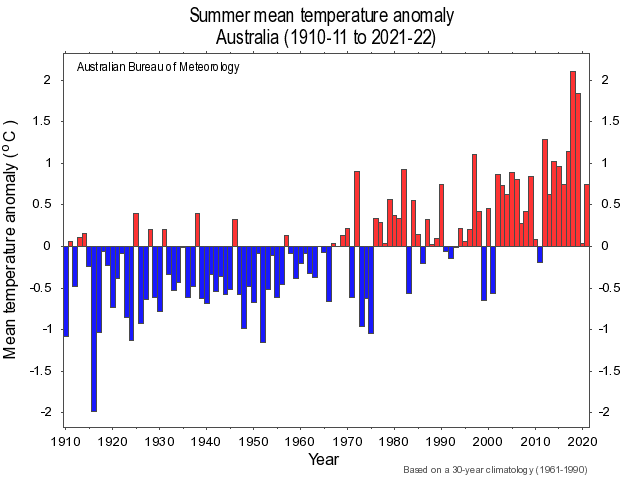

In [5]:
Image(filename='/home/599/dbi599/summer-heat/analysis/tas_BoM_1911-2022_DJF_aus-mean.png')

In [6]:
bom_ds = fileio.open_dataset(bom_file)

In [7]:
bom_ds

<xarray.Dataset>
Dimensions:  (time: 112)
Coordinates:
  * time     (time) object 1911-02-15 00:00:00 ... 2022-02-15 00:00:00
Data variables:
    tas      (time) float64 dask.array<chunksize=(112,), meta=np.ndarray>
Attributes:
    history:  Mon Oct 03 10:31:06 2022: /g/data/xv83/dbi599/miniconda3/envs/u...
    source:   http://www.bom.gov.au/climate/change/index.shtml

In [8]:
years = bom_ds['time'].dt.year.values
bom_df = pd.DataFrame(index=years)
bom_df['tas'] = bom_ds['tas'].values

In [9]:
mean_temperature = bom_df.mean()
print(mean_temperature)

tas    27.461161
dtype: float64


In [10]:
tas2019 = bom_ds['tas'].values.max()
print(tas2019)

29.61


In [11]:
ranked_years = bom_df['tas'].sort_values(ascending=False)
ranked_years.head(n=10)

2019    29.61
2020    29.34
2013    28.79
2018    28.64
1998    28.61
2015    28.52
2016    28.46
1983    28.42
1973    28.40
2006    28.39
Name: tas, dtype: float64

In [12]:
bom_gev_shape, bom_gev_loc, bom_gev_scale = indices.fit_gev(bom_df['tas'].values)
print(f'Shape parameter: {bom_gev_shape:.2f}')
print(f'Location parameter: {bom_gev_loc:.2f}')
print(f'Scale parameter: {bom_gev_scale:.2f}')

Shape parameter: 0.18
Location parameter: 27.20
Scale parameter: 0.62


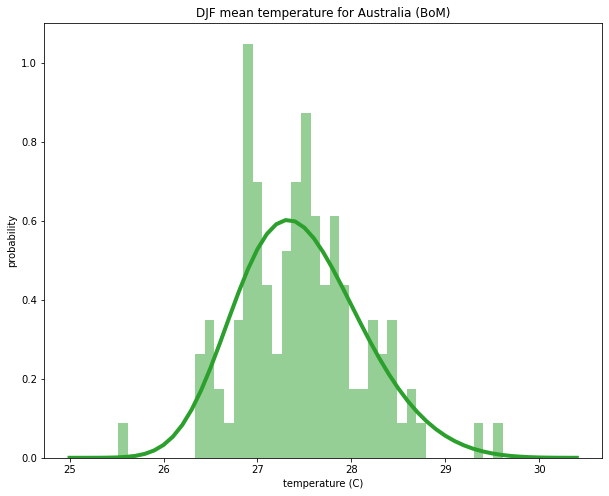

In [13]:
fig, ax = plt.subplots(figsize=[10, 8])
gev_xvals = np.arange(25, 30.5, 0.1)
bom_df['tas'].plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
bom_gev_pdf = gev.pdf(gev_xvals, bom_gev_shape, bom_gev_loc, bom_gev_scale)
plt.plot(gev_xvals, bom_gev_pdf, color='tab:green', linewidth=4.0)
plt.xlabel('temperature (C)')
plt.ylabel('probability')
plt.title(f'DJF mean temperature for Australia (BoM)')
plt.savefig(
    f'/g/data/xv83/dbi599/summer-heat/figures/djf_tas_histogram_aus_BoM.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)

In [14]:
event_probability = gev.sf(tas2019, bom_gev_shape, loc=bom_gev_loc, scale=bom_gev_scale)
event_return_period = 1. / event_probability
event_percentile = (1 - event_probability) * 100
print(f'{event_return_period:.0f} year return period')
print(f'{event_percentile:.2f}% percentile')

759 year return period
99.87% percentile


## Model ensemble

In [15]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:    (ensemble: 10, init_date: 59, lead_time: 11)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    height     float64 ...
  * init_date  (init_date) object 1960-11-16 00:00:00 ... 2018-11-16 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time       (lead_time, init_date) object dask.array<chunksize=(11, 59), meta=np.ndarray>
Data variables:
    tas        (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/48)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    table_info:                Creation Date:(20 July 2018) MD5:b534c310c852a...
    title:                     EC-Earth3 output prepared for CMIP6
    tracking_id:               hdl:21.14100/6f066f42-c15f-4e3b-90ae-696a5b70708a
    variable_id:               tas
    variant_info:              Atmosphere initialization based on full-fields...
    variant_label:             r10i1p1f1

### Independence testing

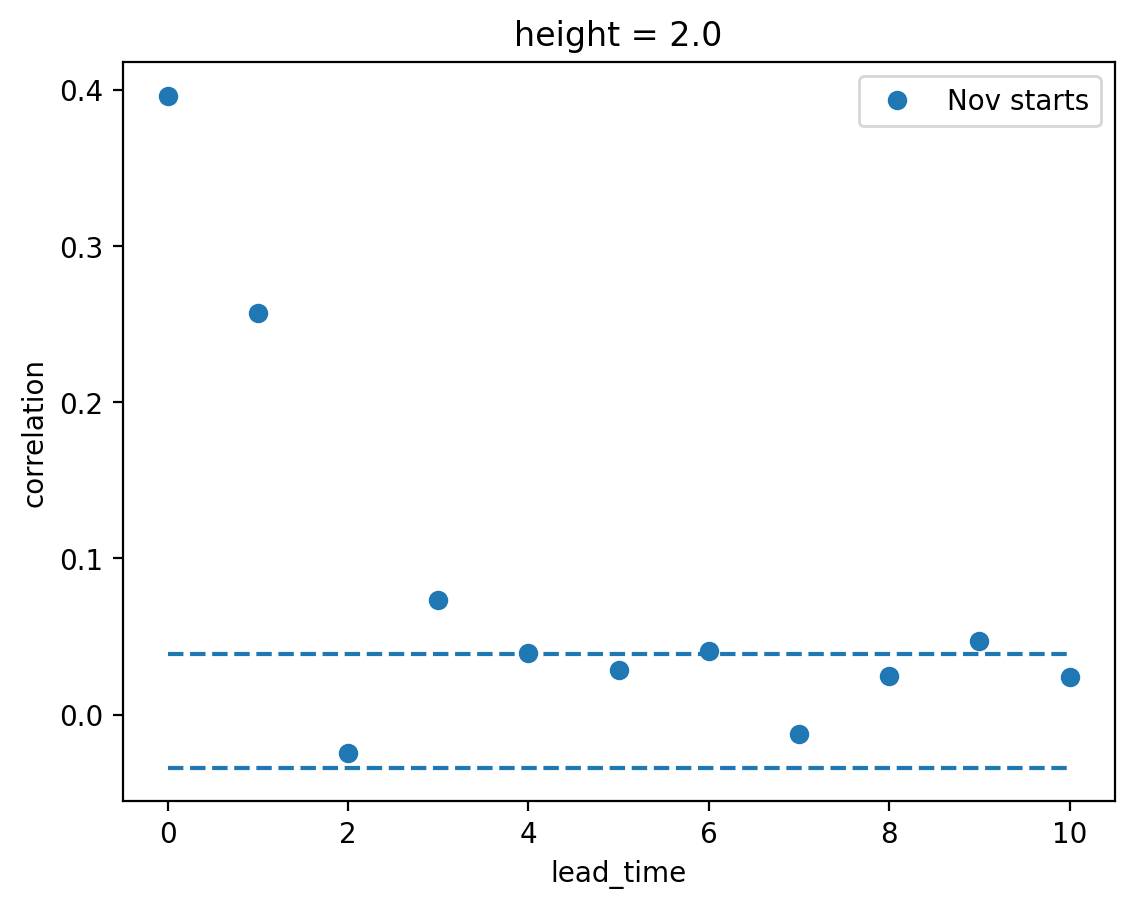

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

2


In [19]:
model_da = model_ds['tas'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

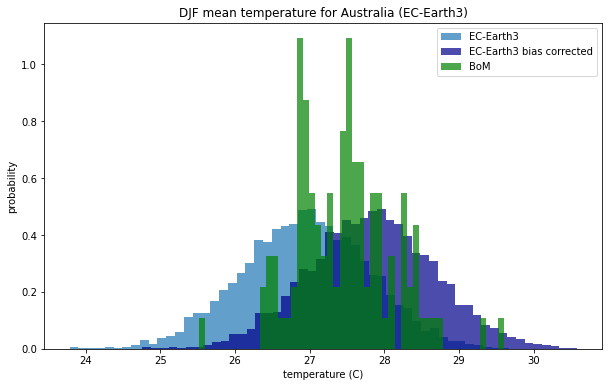

In [20]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['tas'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
bom_ds['tas'].plot.hist(bins=50, density=True, label='BoM', facecolor='green', alpha=0.7)
plt.xlabel('temperature (C)')
plt.ylabel('probability')
plt.title(f'DJF mean temperature for Australia ({model_name})')
plt.legend()
plt.savefig(
    f'/g/data/xv83/dbi599/summer-heat/figures/djf_tas_histogram_aus_{model_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [21]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)
similarity_bias_ds['pval'].values

array([0.73215014, 0.12735316, 0.15137397, 0.13499013, 0.0885983 ,
       0.09427202, 0.02796704, 0.04598224, 0.0643396 ], dtype=float32)

In [22]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)
similarity_raw_ds['pval'].values

array([2.2965966e-15, 4.0626627e-11, 1.0839079e-05, 7.3550727e-10,
       6.5696372e-17, 2.2151443e-12, 1.0704606e-11, 1.2095874e-12,
       2.8584871e-13, 1.2335361e-10, 2.3054681e-11], dtype=float32)

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Exceedance curves

In [23]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'DJF mean temperature for Australia ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('temperature (C)')
    ax.axvline(tas2019, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [24]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    start_years = [1960, 1970, 1980, 1990, 2000, 2010]
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + 9
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, tas2019, 'above')
        print(f'{n_events} events from {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period')

    ax.set_title(f'DJF mean temperature for Australia ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('temperature (C)')
    ax.legend()
    ax.axvline(tas2019, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/summer-heat/figures/dfj_tas_exceedence_aus_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

In [25]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['tas'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [26]:
model_bc_da_stacked.shape

(5310,)

/g/data/xv83/dbi599/summer-heat/figures/djf_tas_exceedence_aus_EC-Earth3.png


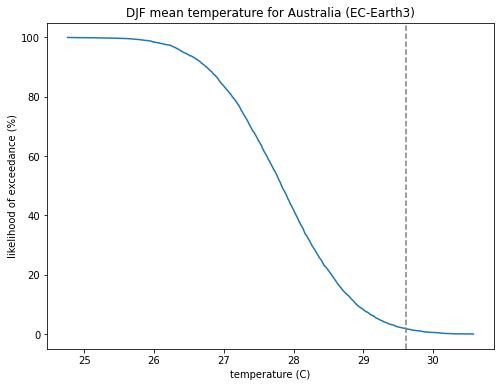

In [27]:
outfile = f'/g/data/xv83/dbi599/summer-heat/figures/djf_tas_exceedence_aus_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [28]:
n_events, n_population, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, tas2019, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events} events from {n_population} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
96 events from 5310 samples
98.19% percentile
55 year return period


1960-1969
1 events from 360 samples
99.72% percentile
360 year return period
1970-1979
2 events from 900 samples
99.78% percentile
450 year return period
1980-1989
1 events from 900 samples
99.89% percentile
900 year return period
1990-1999
2 events from 900 samples
99.78% percentile
450 year return period
2000-2009
10 events from 900 samples
98.89% percentile
90 year return period
2010-2019
38 events from 900 samples
95.78% percentile
24 year return period
/g/data/xv83/dbi599/summer-heat/figures/dfj_tas_exceedence_aus_EC-Earth3_by-decade.png


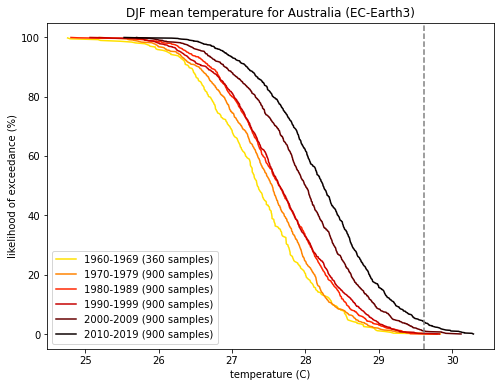

In [29]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

In [30]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [31]:
model_da_stacked.shape

(5310,)

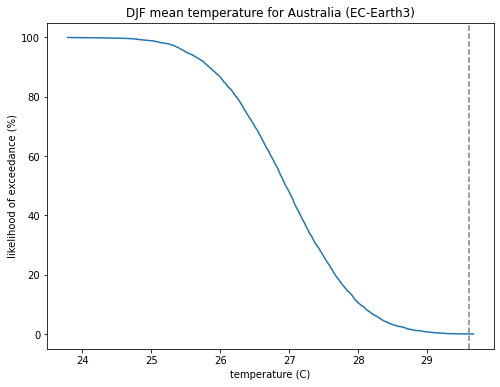

In [32]:
plot_exceedance(model_da_stacked, model_name)

In [33]:
n_events, n_population, return_period_raw, percentile_raw = general_utils.event_in_context(model_da_stacked.values, tas2019, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events} events from {n_population} samples')
print(f'{percentile_raw:.2f}% percentile')
print(f'{return_period_raw:.0f} year return period')

BIAS CORRECTED DATA
1 events from 5310 samples
99.98% percentile
5310 year return period
